### IMAGE COMPLETION

Image Completion is the task of filling missing parts of a given image with the help of information from the known parts of the image. This is an application that takes an image with a missing part as input and gives a completed image as the result.

We will be using Autoencoder to do this task. We will train our network on Images with missing parts passed with true images so that autoencoder can minimize the ture image and corrupted image. 

### Imports

In [ ]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.utils import plot_model
from skimage.io import imread
from PIL import Image, ImageDraw
import cv2 as cv
import math
import h5py
from keras.models import load_model
import json

### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images. 

Mounting your google drive.

In [ ]:
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

Unzipping the data file to load it locally in the colab runtime. You can see your unzipped files by clicking the folder icon on left side of your colab.

In [ ]:
# replace this your google drive path of the zip file of dataset provided with this homework

# !unzip -o -q "/drive/MyDrive/images128x128.zip" -d "/content/data/"

In [ ]:
!gdown "https://drive.google.com/uc?id=1G46RvhLHvf-En1srq9W1if32Edv1BgbP" ## downloading dataset using gdown instead of gdrive mounting

Downloading...
From: https://drive.google.com/uc?id=1G46RvhLHvf-En1srq9W1if32Edv1BgbP
To: /content/images128x128.zip
2.11GB [00:22, 92.1MB/s]


In [ ]:
# !unzip -o -q "/content/1k-vTUJ0_-7sCb7wqtbmxUBIqg0QDhI9F?usp=sharing%2Fimages128x128.zip" -d "/content/data/"
!unzip -o -q "/content/images128x128.zip" -d "/content/data/"


In [ ]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/data/'

# fetching all the filenmaes to 8, 8, 16)  read them later in generator
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))
# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


### Data Generator

The dataset is quite large (70000 images) which makes it impossible to load it all at the same time in computer memory. In you assignment 03 you implemented a custom generator function to load the images in batches, here we are going to do the same. Instead of returning the images and its labels, here we will return tuple <i>(corrupted_images_batch, original_images_batch)</i> from the generator where the corrupted images are the same images as the original but a small square is removed from them.

Below you will create a function to remove a portion of image. This is basically the same as drawing a black square on the image. You function will take a numpy image and return the numpy image with black square on it. 


You images will look somehting like this. The square drawn here is 28x28 (you can be confortable with the dimensions) and it is drawn at a random location with-in the image.

![picture](https://drive.google.com/uc?export=view&id=1qIlWIj1K_qjxoGTUJYeVbiLztnyMOVP_)


<i>HINT: You can use ImageDraw function of PIL</i>

In [ ]:
def draw_square_on_image(image):
    
    output_img = image
    
    ######################## WRITE YOUR CODE BELOW ########################
    random_start_point = np.random.randint(0,100)
    img_draw = ImageDraw.Draw(output_img)
    img_draw.rectangle([(random_start_point,random_start_point),(random_start_point+28,random_start_point+28)], fill='black')
    ########################### END OF YOUR CODE ##########################

    return np.array(output_img)

If you are not fimiliar with generators in python you can a look at it [here](https://realpython.com/introduction-to-python-generators/).

As mentioned above, below generator will return a tuple of <i>(corrupted_images_batch, original_images_batch)</i>.

In [ ]:
def custom_image_generator(files, data_instances, batch_size = 64):

    ######################## WRITE YOUR CODE BELOW ########################

    # to keep track that you don't have invalid index for number of files
    iter = 0

    while True:

        # check if you have a invalid index for files, if yes then reset it
        if (iter*batch_size + batch_size) > len(files):
          iter= 0

        end_iter = iter*batch_size + batch_size

        # Select files (paths/indices) for the batch
        paths = files[iter*batch_size:end_iter]
        
        # Read in each input and perform preprocessing (to batch of images)
        corrupted_images_batch = []
        original_images_batch = []
        for path in paths:
          img =  Image.open(path)
          original_images_batch.append(np.array(img)/255)
          masked_img = draw_square_on_image(img)
          preprocess_img = np.array(masked_img)
          corrupted_images_batch.append(preprocess_img/255)


        # Return a tuple of (corrupted_image_batch, true_image_batch) to feed the network
        corrupted_images_batch = np.array(corrupted_images_batch)
        original_images_batch = np.array(original_images_batch)

        # move to the next batch
        iter = iter + 1

    ########################### END OF YOUR CODE ##########################
    
        yield (corrupted_images_batch, original_images_batch)

Utility function to display grid of images.

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
# create generator object
test_generator = custom_image_generator(filenames, 70000)
(corrupted_images_batch, orig_images_batch) = next(test_generator)

Displaying sample images from batch generator.

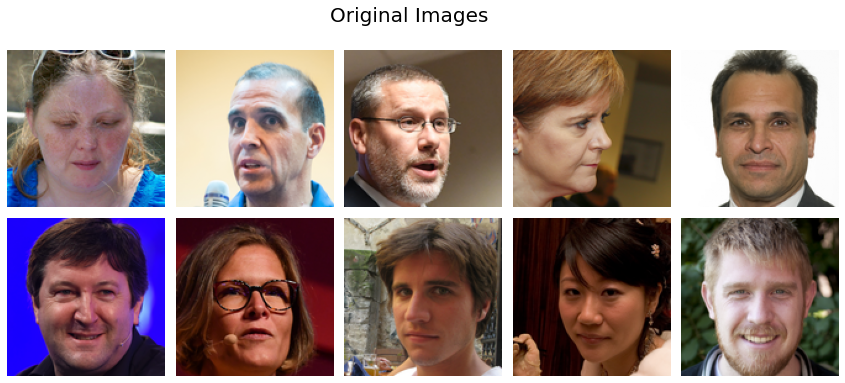

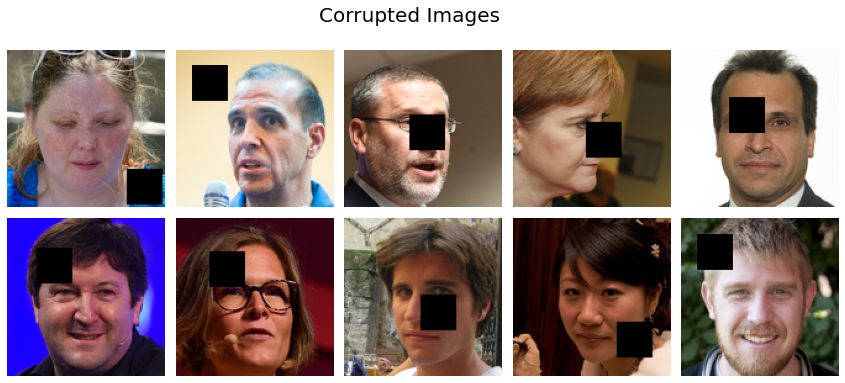

In [ ]:
# get first batch of images
(corrupted_images_batch, orig_images_batch) = next(test_generator)

# only displaying 10 images from both batch
display_image_grid(orig_images_batch[:10], 2, 5, "Original Images")
display_image_grid(corrupted_images_batch[:10], 2, 5, "Corrupted Images")

In [ ]:
no_of_channels = 3
INPUT_DIM = (128,128,no_of_channels) # Image dimension
Z_DIM = [20, 100, 300, 5000]             # Dimension of the latent vector (z)

## Building the Model

#### Encoder

Below you will create the model for the encoder. The architecture of the Encoder consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size <b>Z_DIM</b>. The whole image of size 128x128x3 is decoed into this latent space vector of size <b>Z_DIM</b>.

for i=1 to num_conv:
  - add Covn Layer (filter_size = 32, stride = 2, padding = 'same')
  - add LeakeyReLU

end
- add Dense() (with no activation function)

NOTE: You can also experiment with the number of feature maps, kernel size and strides for each of the conv layer.

You can refer to this [link](https://blog.keras.io/building-autoencoders-in-keras.html) to see how to create autoencoer model in keras.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0     

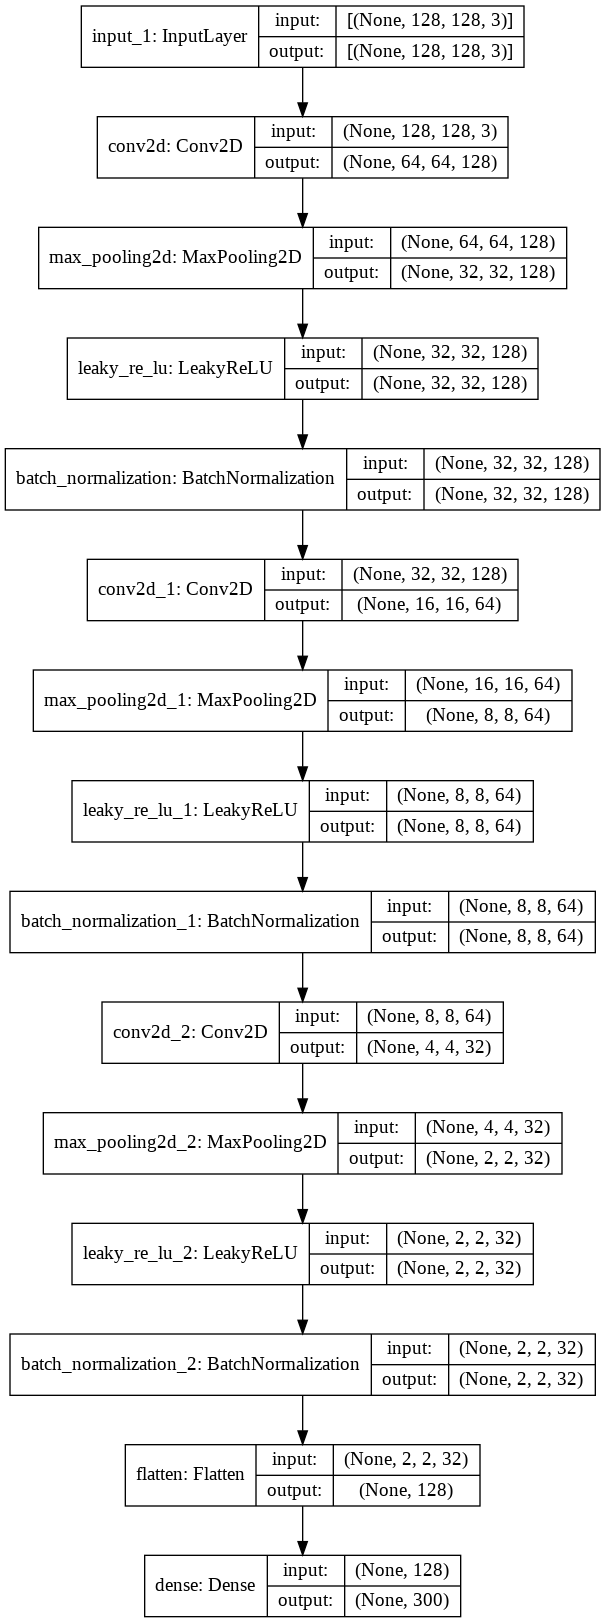

In [ ]:
ae_encoder = None
ae_encoder_output = None
ae_encoder_input = Input(shape = INPUT_DIM, dtype=np.float32)

num_conv = {0: {'filters': 128, 'kernel_size': 5, 'strides': 2},
            1: {'filters': 64, 'kernel_size': 3, 'strides': 2},
            2: {'filters': 32, 'kernel_size': 3, 'strides': 2}}
######################## WRITE YOUR CODE BELOW ########################
encoder = ae_encoder_input
for layer_num,layer_data in num_conv.items():
  encoder = Conv2D(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(encoder)
  encoder = MaxPool2D((2,2),padding='same')(encoder)
  encoder = LeakyReLU(alpha=0.2)(encoder)
  encoder = BatchNormalization(axis=-1)(encoder)


volumeSize = K.int_shape(encoder)
flatten = Flatten()(encoder)
ae_encoder_output = Dense(Z_DIM[2])(flatten)
ae_encoder = Model(ae_encoder_input,ae_encoder_output)
########################### END OF YOUR CODE ##########################

ae_encoder.summary()
tf.keras.utils.plot_model(ae_encoder, show_shapes=True)

#### Decoder

Just like the encoder you will create the model for the decoder. This model will be the exact mirror of encoder model, but that is not mandatory.

Since the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved through the  [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer. This layer produces an output tensor double the size of the input tensor in both height and width. The input to the encoder is the vector of size <b>Z_DIM</b> and output will be a image of size <b>INPUT_DIM</b>. Your final decoder will look something like this: 

<center>

![picture](https://drive.google.com/uc?export=view&id=1QGaPm7byp7YOZqrZx9ARX9hPBVHB9rq5)

</center>

Again, you can experiment with the number of layers, feature size, kernel size and stride of conv layers.

<i>NOTE: Unlike the encoder, there will the activaiton function for decoder, as it will be outputing the image. And we want our pixel values between zero and one. </i>


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               38528     
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 32)          128 

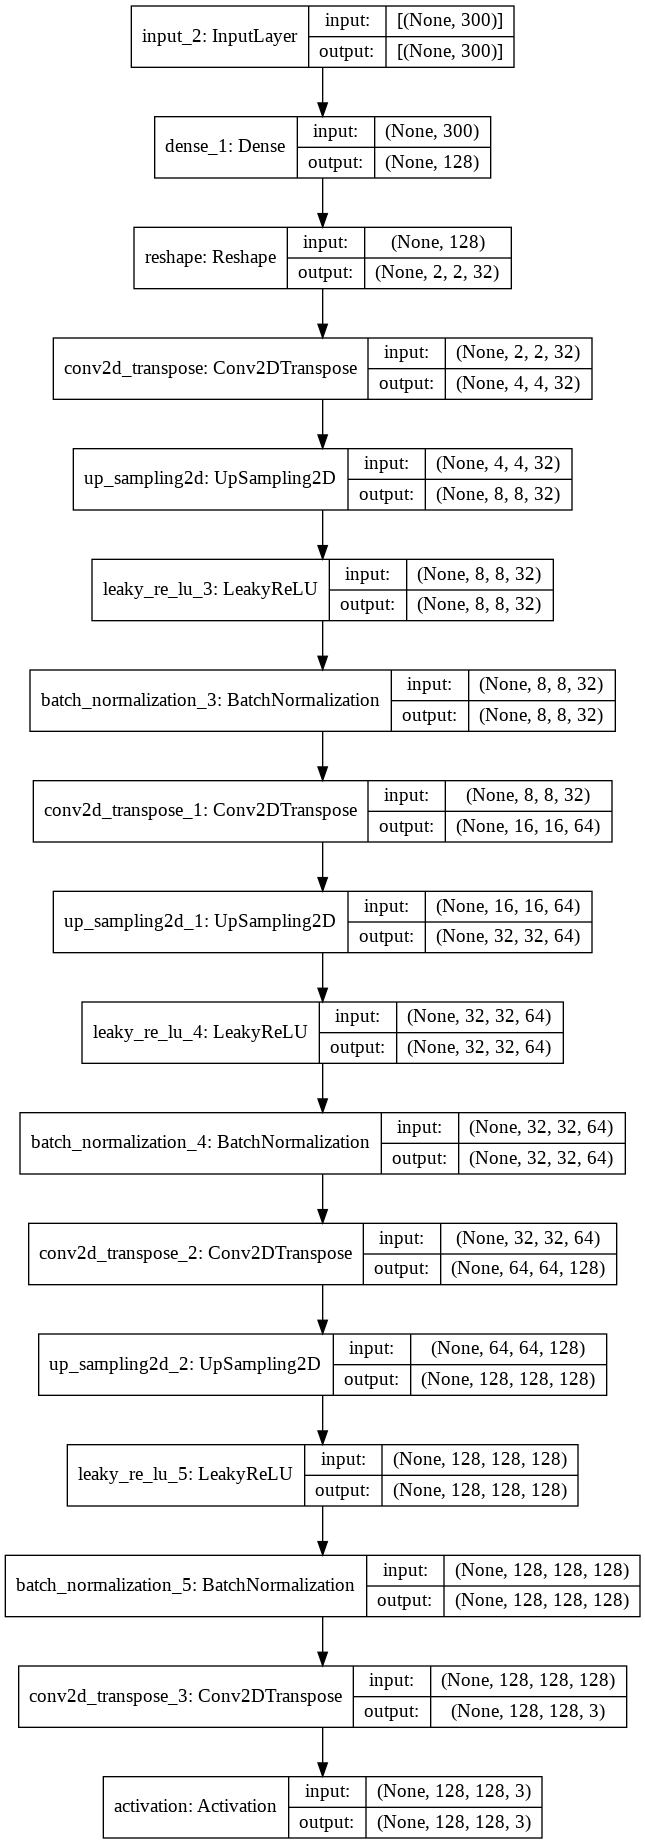

In [ ]:
ae_decoder = None
ae_decoder_output = None
ae_decode_input = Input(shape=(Z_DIM[2],))

decoder = Dense(np.prod(volumeSize[1:]))(ae_decode_input)
decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)
######################## WRITE YOUR CODE BELOW ########################
for layer_num,layer_data in reversed(sorted(num_conv.items())):
  decoder = Conv2DTranspose(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(decoder)
  decoder = UpSampling2D(size=(2,2))(decoder)
  decoder = LeakyReLU(alpha=0.2)(decoder)
  decoder = BatchNormalization(axis=-1)(decoder)


decoder = Conv2DTranspose(no_of_channels, 3, padding='same')(decoder)
ae_decoder_output = Activation('sigmoid')(decoder)

ae_decoder = Model(ae_decode_input, ae_decoder_output)
########################### END OF YOUR CODE ##########################

ae_decoder.summary()
tf.keras.utils.plot_model(ae_decoder, show_shapes=True)

#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [ ]:
autoencoder_model = None

######################## WRITE YOUR CODE BELOW ########################

# The input of the autoencoder will be the same as of encoder
autoencoder_input = ae_encoder_input
# The output of the autoencoder will be the output of decoder, when passed encoder input
autoencoder_output =  ae_decoder(ae_encoder(ae_encoder_input))

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.

autoencoder_model = Model(autoencoder_input, autoencoder_output)
########################### END OF YOUR CODE ##########################

autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 300)               141580    
_________________________________________________________________
model_1 (Functional)         (None, 128, 128, 3)       275555    
Total params: 417,135
Trainable params: 416,239
Non-trainable params: 896
_________________________________________________________________


## Training the AE

Finally you will compile your autoencoer here. 

Here are few hyperparamters to consider here:
- Learning rate [0.1, 0.00001]
- Training epochs [5, 50]
- batch_size [64, 512]
- Latent vector size [20, 5000]
- Error function 
- Optimizer

## Model trained with Hyperparameters listed below:
1. Learning rate: 0.01, 0.001
2. Optimizers: Adam, SGD
3. Loss: mse
4. batch size: 64
5. epochs: 15
6. latent_space: 300

epoch :  15  lr :  0.01  batch size :  64  optim :  Adam  loss:  mse
Epoch 1/15
1093/1093 [==============================] - 174s 157ms/step - loss: 0.0380 - accuracy: 0.7599
Epoch 2/15
1093/1093 [==============================] - 172s 158ms/step - loss: 0.0171 - accuracy: 0.8168
Epoch 3/15
1093/1093 [==============================] - 173s 158ms/step - loss: 0.0152 - accuracy: 0.8214
Epoch 4/15
1093/1093 [==============================] - 172s 158ms/step - loss: 0.0142 - accuracy: 0.8291
Epoch 5/15
1093/1093 [==============================] - 172s 158ms/step - loss: 0.0136 - accuracy: 0.8346
Epoch 6/15
1093/1093 [==============================] - 173s 158ms/step - loss: 0.0133 - accuracy: 0.8368
Epoch 7/15
1093/1093 [==============================] - 173s 158ms/step - loss: 0.0130 - accuracy: 0.8378
Epoch 8/15
1093/1093 [==============================] - 173s 158ms/step - loss: 0.0128 - accuracy: 0.8381
Epoch 9/15
1093/1093 [==============================] - 173s 158ms/step - loss: 0.0

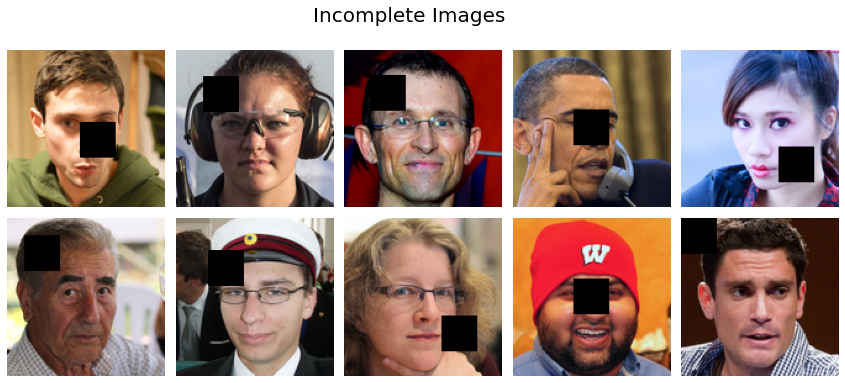

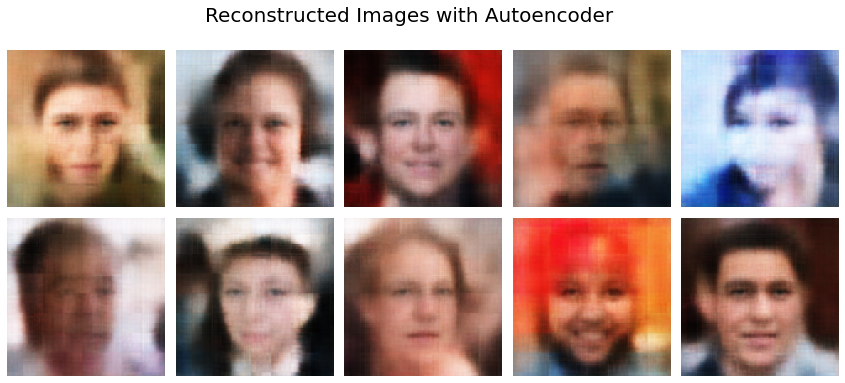

epoch :  15  lr :  0.01  batch size :  64  optim :  SGD  loss:  mse
Epoch 1/15
1093/1093 [==============================] - 180s 164ms/step - loss: 0.0120 - accuracy: 0.8266
Epoch 2/15
1093/1093 [==============================] - 180s 165ms/step - loss: 0.0119 - accuracy: 0.8353
Epoch 3/15
1093/1093 [==============================] - 180s 164ms/step - loss: 0.0119 - accuracy: 0.8384
Epoch 4/15
1093/1093 [==============================] - 180s 165ms/step - loss: 0.0119 - accuracy: 0.8401
Epoch 5/15
1093/1093 [==============================] - 180s 165ms/step - loss: 0.0118 - accuracy: 0.8413
Epoch 6/15
1093/1093 [==============================] - 179s 164ms/step - loss: 0.0118 - accuracy: 0.8420
Epoch 7/15
1093/1093 [==============================] - 180s 165ms/step - loss: 0.0118 - accuracy: 0.8423
Epoch 8/15
1093/1093 [==============================] - 180s 165ms/step - loss: 0.0118 - accuracy: 0.8425
Epoch 9/15
1093/1093 [==============================] - 180s 164ms/step - loss: 0.01

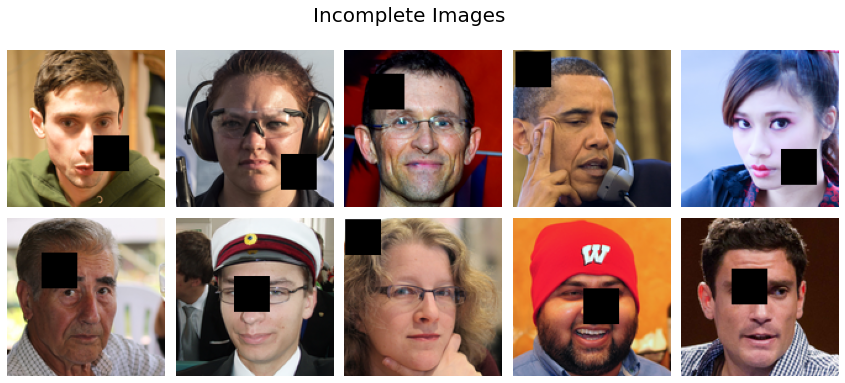

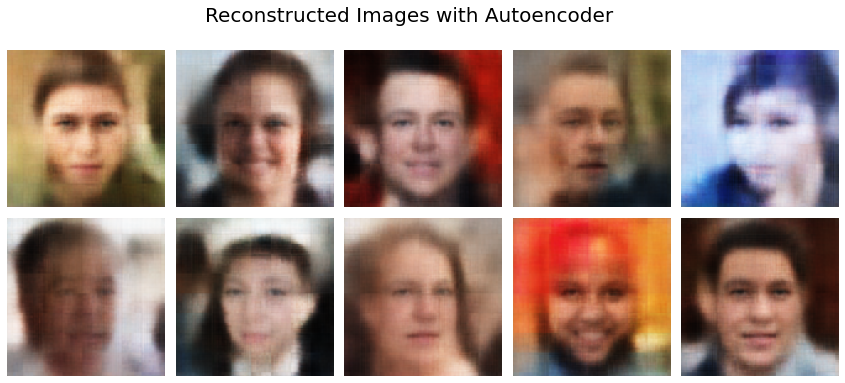

epoch :  15  lr :  0.001  batch size :  64  optim :  Adam  loss:  mse
Epoch 1/15
1093/1093 [==============================] - 183s 166ms/step - loss: 0.0114 - accuracy: 0.8465
Epoch 2/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0113 - accuracy: 0.8471
Epoch 3/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0113 - accuracy: 0.8471
Epoch 4/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0113 - accuracy: 0.8472
Epoch 5/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0112 - accuracy: 0.8472
Epoch 6/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0112 - accuracy: 0.8472
Epoch 7/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0112 - accuracy: 0.8472
Epoch 8/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0112 - accuracy: 0.8472
Epoch 9/15
1093/1093 [==============================] - 182s 167ms/step - loss: 0.

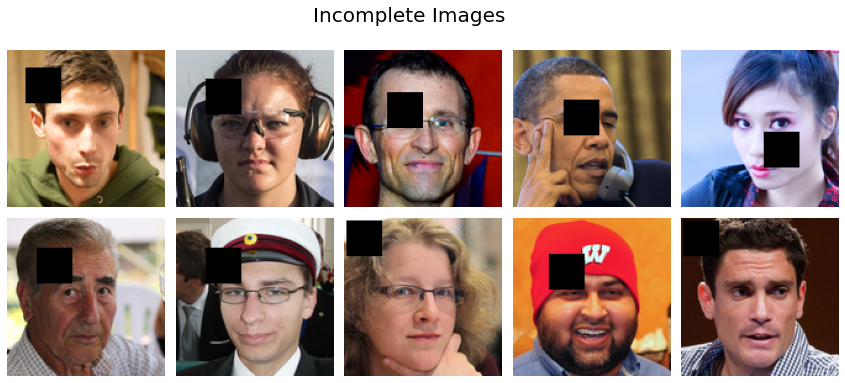

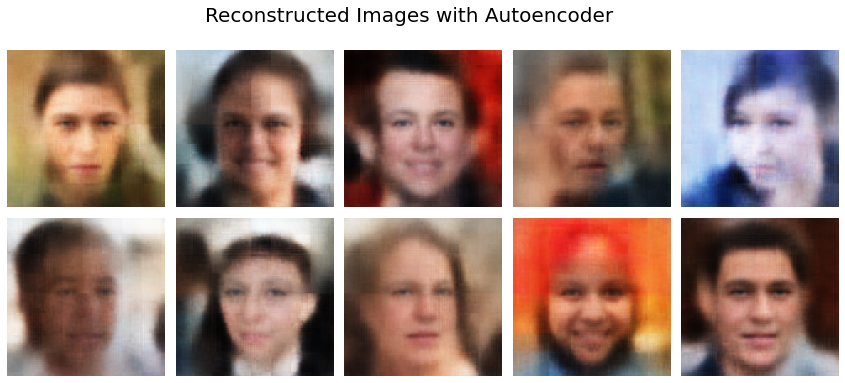

epoch :  15  lr :  0.001  batch size :  64  optim :  SGD  loss:  mse
Epoch 1/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0111 - accuracy: 0.8475
Epoch 2/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0111 - accuracy: 0.8473
Epoch 3/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0111 - accuracy: 0.8472
Epoch 4/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0111 - accuracy: 0.8472
Epoch 5/15
1093/1093 [==============================] - 182s 166ms/step - loss: 0.0111 - accuracy: 0.8470
Epoch 6/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0111 - accuracy: 0.8470
Epoch 7/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0111 - accuracy: 0.8469
Epoch 8/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0111 - accuracy: 0.8468
Epoch 9/15
1093/1093 [==============================] - 181s 166ms/step - loss: 0.0

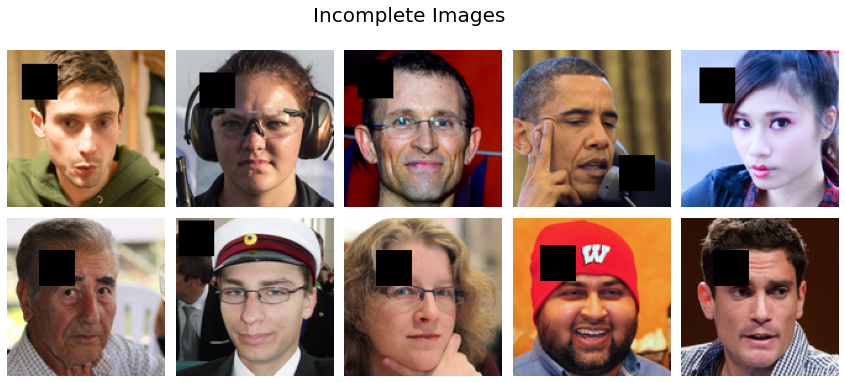

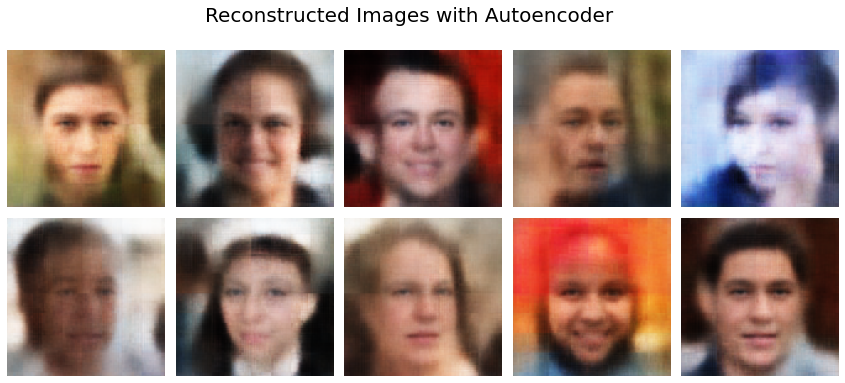

In [ ]:
BATCH_SIZE =  [64]       # batch of images returned by image generator
N_EPOCHS = [15]         # epochs
LEARNING_RATE = [0.01,  0.001]    # learning rate
OPTIMIZERS = [Adam(),SGD()]
LOSS = ['mse']

######################## WRITE YOUR CODE BELOW ########################
model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', optim.get_config()['name'], ' loss: ', k_loss)
          train_generator = custom_image_generator(filenames, NUM_IMAGES, batch_size) ## CREATE CUSTOM GENERATOR
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss, optimizer=optim, metrics='accuracy') ## MODEL COMPILING
          autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES /batch_size, epochs=epoch)

          ## RECONSTRUCTION
          test_gen = custom_image_generator(filenames, NUM_IMAGES, batch_size)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)
          display_image_grid(test_images, 2, 5, "Incomplete Images")
          display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

        ## save model
          model_to_json = autoencoder_model.to_json()
          path_to_save = str(model)+'_epoch : '+ str(epoch)+ ' learning_rate : '+str(learning_rate) + ' optimizer : ' + optim.get_config()['name']+ ' batch_size : '+ str(batch_size) + ' k_loss : '+ k_loss + '.h5' 
          autoencoder_model.save(path_to_save)
          save_model_paths.append(path_to_save)
          model += 1 ## count no-of models




########################### END OF YOUR CODE ##########################

## Model trained with Hyperparameters listed below:
1. latent space: 5000
2. epochs: 30
3. learning rate: 0.0001
4. Batch size: 32
5. optimizer: Adam
6. loss: mse


epoch :  30  lr :  0.0001  batch size :  32  optim :  Adam  loss:  mse
Epoch 1/30
2187/2187 [==============================] - 143s 65ms/step - loss: 0.0380 - accuracy: 0.6832
Epoch 2/30
2187/2187 [==============================] - 141s 65ms/step - loss: 0.0203 - accuracy: 0.8064
Epoch 3/30
2187/2187 [==============================] - 141s 64ms/step - loss: 0.0181 - accuracy: 0.8127
Epoch 4/30
2187/2187 [==============================] - 141s 64ms/step - loss: 0.0168 - accuracy: 0.8159
Epoch 5/30
2187/2187 [==============================] - 139s 64ms/step - loss: 0.0160 - accuracy: 0.8180
Epoch 6/30
2187/2187 [==============================] - 138s 63ms/step - loss: 0.0155 - accuracy: 0.8198
Epoch 7/30
2187/2187 [==============================] - 140s 64ms/step - loss: 0.0151 - accuracy: 0.8212
Epoch 8/30
2187/2187 [==============================] - 140s 64ms/step - loss: 0.0148 - accuracy: 0.8222
Epoch 9/30
2187/2187 [==============================] - 141s 64ms/step - loss: 0.0145 - a

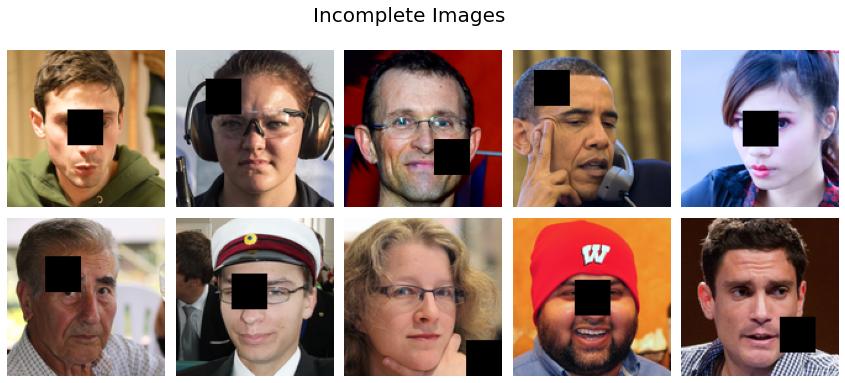

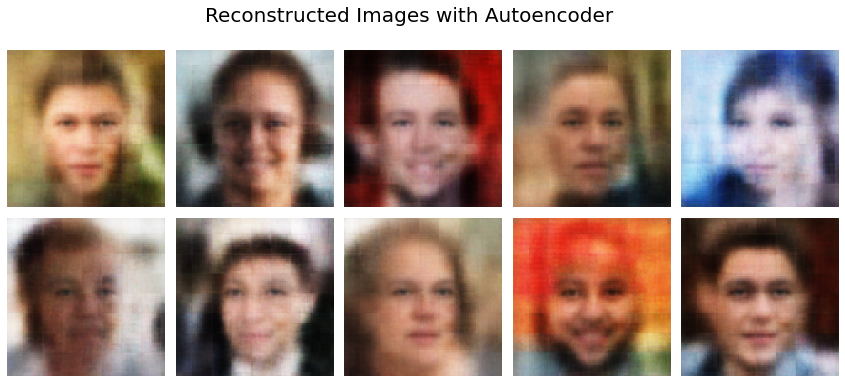

In [ ]:

BATCH_SIZE =  [32]       # batch of images returned by image generator
N_EPOCHS = [30]         # epochs
LEARNING_RATE = [0.0001]    # learning rate
OPTIMIZERS = [Adam()]
LOSS = ['mse']

######################## WRITE YOUR CODE BELOW ########################
model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', optim.get_config()['name'], ' loss: ', k_loss)
          train_generator = custom_image_generator(filenames, NUM_IMAGES, batch_size) ## CUSTOM GENERATOR
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss, optimizer=optim, metrics='accuracy') ## MODEL COMPILE
          autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES /batch_size, epochs=epoch)

          ## RECONSTRUCTION
          test_gen = custom_image_generator(filenames, NUM_IMAGES, batch_size)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)
          display_image_grid(test_images, 2, 5, "Incomplete Images")
          display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

        ## save model
          model_to_json = autoencoder_model.to_json()
          path_to_save = str(model)+'_epoch : '+ str(epoch)+ ' learning_rate : '+str(learning_rate) + ' optimizer : ' + optim.get_config()['name']+ ' batch_size : '+ str(batch_size) + ' k_loss : '+ k_loss + '.h5' 
          autoencoder_model.save(path_to_save)
          save_model_paths.append(path_to_save)
          model += 1 ## count no-of models



########################### END OF YOUR CODE ##########################

## Model trained with Hyperparameters listed below:
1. latent space: 20
2. epochs: 10
3. learning rate: 0.01
4. Batch size: 64
5. Optimizer: RmsProp
5. Loss: binary cross entropy


epoch :  10  lr :  0.01  batch size :  64  optim :  RMSprop  loss:  binary_crossentropy
Epoch 1/10
1093/1093 [==============================] - 140s 127ms/step - loss: 0.6886 - accuracy: 0.7465
Epoch 2/10
1093/1093 [==============================] - 138s 126ms/step - loss: 0.5757 - accuracy: 0.7973
Epoch 3/10
1093/1093 [==============================] - 137s 125ms/step - loss: 0.5740 - accuracy: 0.7998
Epoch 4/10
1093/1093 [==============================] - 136s 124ms/step - loss: 0.5731 - accuracy: 0.8009
Epoch 5/10
1093/1093 [==============================] - 135s 124ms/step - loss: 0.5727 - accuracy: 0.8009
Epoch 6/10
1093/1093 [==============================] - 135s 124ms/step - loss: 0.5722 - accuracy: 0.8015
Epoch 7/10
1093/1093 [==============================] - 135s 124ms/step - loss: 0.5719 - accuracy: 0.8019
Epoch 8/10
1093/1093 [==============================] - 136s 124ms/step - loss: 0.5717 - accuracy: 0.8012
Epoch 9/10
1093/1093 [==============================] - 136s 124

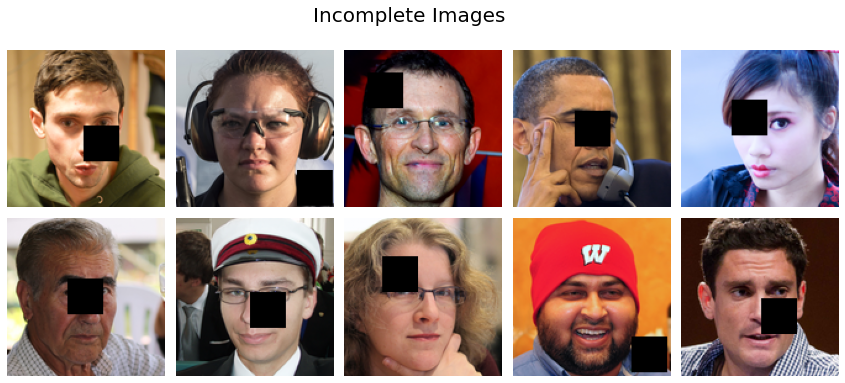

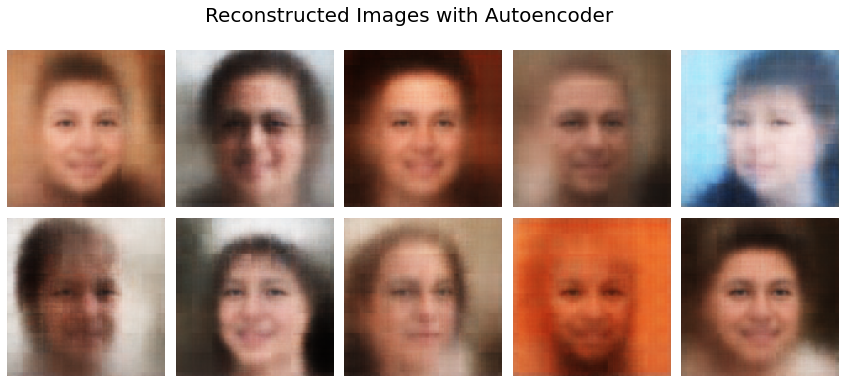

In [ ]:

BATCH_SIZE =  [64]       # batch of images returned by image generator
N_EPOCHS = [10]         # epochs
LEARNING_RATE = [0.01]    # learning rate
OPTIMIZERS = [RMSprop()]
LOSS = ['binary_crossentropy']

######################## WRITE YOUR CODE BELOW ########################
model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', optim.get_config()['name'], ' loss: ', k_loss)
          train_generator = custom_image_generator(filenames, NUM_IMAGES, batch_size) 
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss, optimizer=optim, metrics='accuracy')
          autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES /batch_size, epochs=epoch)

          ## RECONSTRUCTION
          test_gen = custom_image_generator(filenames, NUM_IMAGES, batch_size)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)
          display_image_grid(test_images, 2, 5, "Incomplete Images")
          display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

        ## save model
          model_to_json = autoencoder_model.to_json()
          path_to_save = str(model)+'_epoch : '+ str(epoch)+ ' learning_rate : '+str(learning_rate) + ' optimizer : ' + optim.get_config()['name']+ ' batch_size : '+ str(batch_size) + ' k_loss : '+ k_loss + '.h5' 
          autoencoder_model.save(path_to_save)
          save_model_paths.append(path_to_save)
          model += 1 ## count no-of models


########################### END OF YOUR CODE ##########################

Now simply call the <i>fit</i> function of the model with the appropriate paramters.

<i> HINT: Pass step_per_epoch to be equal to total images divided by batch_size. As you want to see all your data in a single epoch. </i>

In [ ]:
######################## WRITE YOUR CODE BELOW ########################

# hist = autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES / BATCH_SIZE[0], epochs=N_EPOCHS[0])
########################### END OF YOUR CODE ##########################

## Reconstruction

Now we will get a batch of images from data generator object and try to reproduce it by passing through AE.

The first image grid shows the original images and the second grid shows the reconstructed images after passing it through the AE.

In [ ]:

# test_gen = custom_image_generator(filenames, NUM_IMAGES)

# test_batch = next(test_gen)[0]
# test_images = test_batch[:10]

# reconst_images = autoencoder_model.predict(test_images)

# display_image_grid(test_images, 2, 5, "Incomplete Images")
# display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

## <b>Model trained with Hyperparameters listed below:  BEST RESULTS!</b>
1. latent space: 300
2. epochs: 50
3. learning rate: 0.001
4. Batch size: 64
5. optimzer: adam
6. loss: mse


epoch :  50  lr :  0.001  batch size :  64  optim :  Adam  loss:  mse
Epoch 1/50
1093/1093 [==============================] - 258s 207ms/step - loss: 0.0321 - accuracy: 0.7512
Epoch 2/50
1093/1093 [==============================] - 228s 209ms/step - loss: 0.0171 - accuracy: 0.8193
Epoch 3/50
1093/1093 [==============================] - 228s 208ms/step - loss: 0.0152 - accuracy: 0.8246
Epoch 4/50
1093/1093 [==============================] - 228s 209ms/step - loss: 0.0143 - accuracy: 0.8270
Epoch 5/50
1093/1093 [==============================] - 228s 209ms/step - loss: 0.0137 - accuracy: 0.8286
Epoch 6/50
1093/1093 [==============================] - 228s 208ms/step - loss: 0.0134 - accuracy: 0.8296
Epoch 7/50
1093/1093 [==============================] - 228s 208ms/step - loss: 0.0130 - accuracy: 0.8359
Epoch 8/50
1093/1093 [==============================] - 228s 209ms/step - loss: 0.0127 - accuracy: 0.8400
Epoch 9/50
1093/1093 [==============================] - 228s 208ms/step - loss: 0.

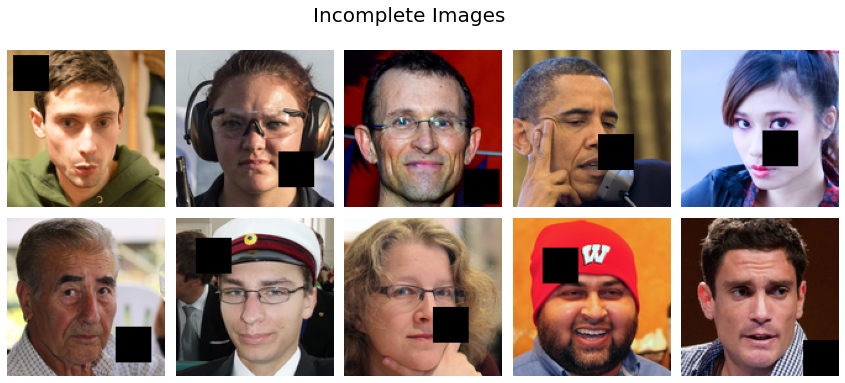

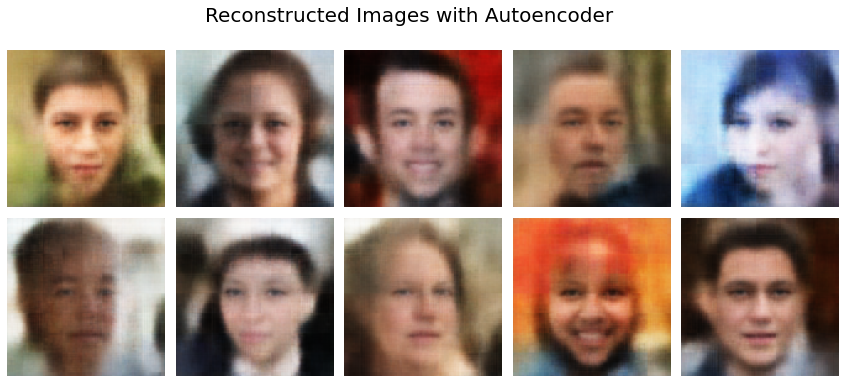

In [ ]:
BATCH_SIZE = [64]       # batch of images returned by image generator
N_EPOCHS = [50]        # epochs
LEARNING_RATE = [0.001]    # learning rate
OPTIMIZERS = [Adam()]
LOSS = ['mse']

######################## WRITE YOUR CODE BELOW ########################
model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', optim.get_config()['name'], ' loss: ', k_loss)
          train_generator = custom_image_generator(filenames, 70000, batch_size) 
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss, optimizer=optim, metrics='accuracy')
          autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES /batch_size, epochs=epoch)

          ## RECONSTRUCTION
          test_gen = custom_image_generator(filenames, NUM_IMAGES)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)
          display_image_grid(test_images, 2, 5, "Incomplete Images")
          display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

        ## save model
          model_to_json = autoencoder_model.to_json()
          path_to_save = str(model)+'_epoch : '+ str(epoch)+ ' learning_rate : '+str(learning_rate) + ' optimizer : ' + optim.get_config()['name']+ ' batch_size : '+ str(batch_size) + ' k_loss : '+ k_loss + '.h5' 
          autoencoder_model.save(path_to_save)
          save_model_paths.append(path_to_save)
          model += 1 ## count no-of models




########################### END OF YOUR CODE ##########################

## REPORT

Report your results for different values of <b>Z_DIM</b>, <b>learning rate</b>, <b>optimizers</b>, <b> encoder and decoder model</b> and tell us for which configuration you acheived the best results (The best run model should be the last run model in this notebook, showing the results in the cell above).

Your answer:
Had trained models for various combinations of parameters: 
- Model 1 with accuracy: <b>83.92%</b> and loss: <b>0.0121</b> following parameters:
1. epoch :  15  
2. learning rate :  0.01  
3. batch size :  64  
4. optim :  Adam  
5. loss:  mse
6. Z_DIM: 300

- Model 2 with accuracy: <b>84.33%</b> and loss: <b>0.0118</b> following parameters:
1. epoch :  15  
2. learning rate :  0.01  
3. batch size :  64  
4. optim :  SGD  
5. loss:  mse
6. Z_DIM: 300


- Model 3 with accuracy: <b>84.75%</b> and loss: <b>0.0111</b> following parameters:
1. epoch :  15  
2. learning rate :  0.001  
3. batch size :  64  
4. optim :  Adam  
5. loss:  mse
6. Z_DIM: 300


- Model 4 with accuracy: <b>84.69%</b> and loss: <b>0.0111</b> following parameters:
1. epoch :  15  
2. learning rate :  0.001  
3. batch size :  64  
4. optim :  SGD  
5. loss:  mse
6. Z_DIM: 300


- Model 5 with accuracy: <b>83.57%</b> and loss: <b>0.0125</b> following parameters:
1. epoch :  30  
2. learning rate :  0.0001  
3. batch size :  32  
4. optim :  Adam  
5. loss:  mse
6. Z_DIM: 5000

- Model 6 with accuracy: <b>80.22%</b> and loss: <b>0.5712</b> following parameters:
1. epoch :  10  
2. learning rate :  0.01  
3. batch size :  64
4. optim :  RmsProp
5. loss:  binary cross entropy
6. Z_DIM: 20



the best parameters are found in last trained cell having accuracy: <b> 85.10% </b> and loss: <b>0.0111</b>  with following parameters:

1. Z_DIM: 300
2. epochs: 50
3. learning rate: 0.001
4. Batch size: 64
5. optimzer: adam
6. loss: mse
